In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

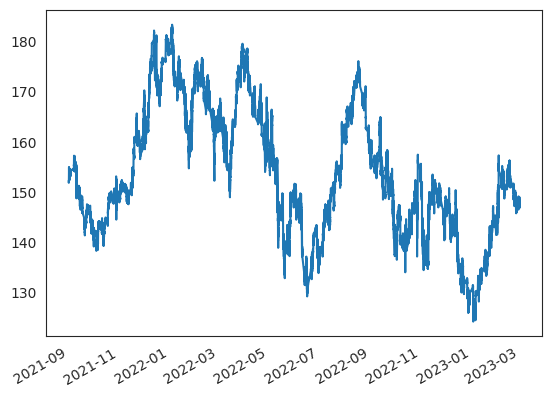

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.40,151.80,0.000591,0.003348,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,0.948276,0.871648,0.948276,0.816092,466.666667,500.000000,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.40,151.80,0.000591,0.003348,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,0.896552,0.911239,0.896552,0.892720,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.6

In [3]:
## INDICATORS STRATEGIES DF ##

df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df_inds.close.plot()
plt.show()
df_inds

In [4]:
# # ##### 101 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (23, 33),
#  'rsi_max_thresh': (50, 50),
#  'adx_thresh': (54.52567693462544, 54.58429306537457),
#  'atr_mult': (17.198027201233764, 18.036792798766236),
#  'vwap_atr_mult': (0.6750593038610649, 0.7075606961389352),
#  'buy_factor': (0.8830246662745681, 0.9099453337254318),
#  'sell_factor': (0.023283027013426515, 0.039126972986573486),
#  'trailstop_pct': (24.136946735051815, 32.26776326494819),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

In [5]:
# Pre-compute per-day slices once
groups = df_inds.groupby(df_inds.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 23, 33)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 49), 51)
    adx_thresh       = trial.suggest_float("adx_thresh", 54.5, 54.6)
    atr_mult         = trial.suggest_float("atr_mult", 17, 18, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 0.67, 0.72)
    buy_factor       = trial.suggest_float("buy_factor", 0.88, 0.91)
    sell_factor      = trial.suggest_float("sell_factor", 0.02, 0.04)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 24.0, 32.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    "ema_3|ema_8",
                                                    # "ema_5|ema_13",
                                                    # "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: 
        sign_thresh = float(sign_thresh) # convert numeric thresholds (only if it´s numeric)
    except ValueError:
        pass # the threshold is a signal
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    acc = opts.TrialAccumulator(trial, pbar, report_interval=report_interval, prun_perc=prun_perc)
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        # process results and possibly prune
        acc.process(sim_results, step, parse_eq_value_callable=strats._parse_eq_value)

        # cleanup
        del df_actions, sim_results
        df_day = df_actions = sim_results = None

    # finalize and return objective
    return acc.finalize()


Baseline mean daily B&H: -9.5162


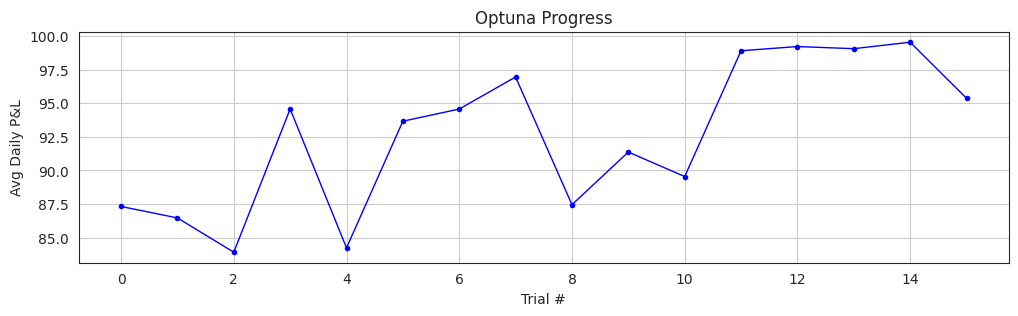

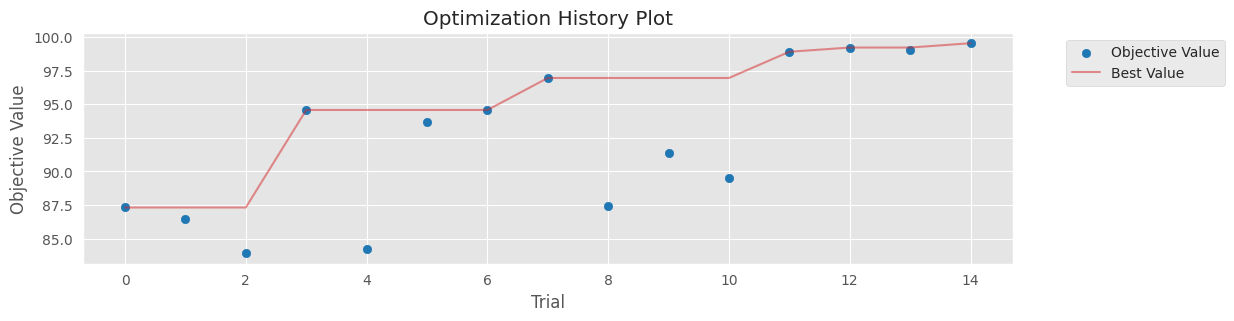

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=51; adx_thresh=54.59017160328557; atr_mult=17.803244827648903; vwap_atr_mult=0.6810101774259174; buy_factor=0.9008918942676748; sell_factor=0.03884959046373945; trailstop_pct=30.705025150626167; sign_thresh_pair=ema_3|ema_8


Trial 0: 100%|██████████| 375/375 [00:48<00:00,  7.77it/s]


[Results] mean_pnl:78.5672 mean_bh:-8.7491 mean_excess:87.3163 improv_vs_bh:998.00%
Action counts: {'Buy': 639, 'Sell': 17051, 'Hold': 333021}
Best trial is: 0 with best_val: 87.3163
[save_results] wrote optuna_results/AAPL_87.3163_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_87.3163_pred_IND.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.55995110600514; atr_mult=17.768035724326086; vwap_atr_mult=0.715803872901174; buy_factor=0.8847597378502516; sell_factor=0.02664520013370338; trailstop_pct=28.912696086995787; sign_thresh_pair=ema_3|ema_8


Trial 1: 100%|██████████| 375/375 [00:35<00:00, 10.53it/s]


[Results] mean_pnl:77.7164 mean_bh:-8.7491 mean_excess:86.4655 improv_vs_bh:988.28%
Action counts: {'Buy': 643, 'Sell': 19669, 'Hold': 330399}
Best trial is: 0 with best_val: 87.3163
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.52643465989241; atr_mult=17.040478331639697; vwap_atr_mult=0.7036384199365605; buy_factor=0.8827037127632883; sell_factor=0.03329666055515558; trailstop_pct=27.905726070757698; sign_thresh_pair=ema_3|ema_8


Trial 2: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:75.1623 mean_bh:-8.7491 mean_excess:83.9114 improv_vs_bh:959.09%
Action counts: {'Buy': 701, 'Sell': 18747, 'Hold': 331263}
Best trial is: 0 with best_val: 87.3163
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=54.56533565237551; atr_mult=17.2039211593662; vwap_atr_mult=0.699498895873148; buy_factor=0.8841570468297396; sell_factor=0.03664525546180543; trailstop_pct=28.31499250385702; sign_thresh_pair=ema_3|ema_8


Trial 3: 100%|██████████| 375/375 [00:36<00:00, 10.35it/s]


[Results] mean_pnl:85.8251 mean_bh:-8.7491 mean_excess:94.5742 improv_vs_bh:1080.96%
Action counts: {'Buy': 668, 'Sell': 17039, 'Hold': 333004}
Best trial is: 3 with best_val: 94.5742
[save_results] wrote optuna_results/AAPL_94.5742_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_94.5742_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.596510136184925; atr_mult=17.60866830337987; vwap_atr_mult=0.7131994685405153; buy_factor=0.8875898136316903; sell_factor=0.022824767552909225; trailstop_pct=24.613105309038815; sign_thresh_pair=ema_3|ema_8


Trial 4: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:75.4875 mean_bh:-8.7491 mean_excess:84.2366 improv_vs_bh:962.80%
Action counts: {'Buy': 653, 'Sell': 22092, 'Hold': 327966}
Best trial is: 3 with best_val: 94.5742
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.56063025479553; atr_mult=17.088311560995102; vwap_atr_mult=0.6860235566636335; buy_factor=0.9072111504797354; sell_factor=0.0296569294487075; trailstop_pct=30.090055752214248; sign_thresh_pair=ema_3|ema_8


Trial 5: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:84.9147 mean_bh:-8.7491 mean_excess:93.6638 improv_vs_bh:1070.55%
Action counts: {'Buy': 641, 'Sell': 19935, 'Hold': 330135}
Best trial is: 3 with best_val: 94.5742
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=54.5946544681433; atr_mult=17.603203379164178; vwap_atr_mult=0.6851593905214453; buy_factor=0.8963283584495328; sell_factor=0.032849969776170204; trailstop_pct=24.309057954863643; sign_thresh_pair=ema_3|ema_8


Trial 6: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:85.8209 mean_bh:-8.7491 mean_excess:94.5700 improv_vs_bh:1080.91%
Action counts: {'Buy': 619, 'Sell': 17866, 'Hold': 332226}
Best trial is: 3 with best_val: 94.5742
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.58541572111853; atr_mult=17.894825054188228; vwap_atr_mult=0.6940258343381432; buy_factor=0.8902278352765896; sell_factor=0.021200731541246767; trailstop_pct=31.33066558073948; sign_thresh_pair=ema_3|ema_8


Trial 7: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:88.2071 mean_bh:-8.7491 mean_excess:96.9562 improv_vs_bh:1108.19%
Action counts: {'Buy': 632, 'Sell': 22144, 'Hold': 327935}
Best trial is: 7 with best_val: 96.9562
[save_results] wrote optuna_results/AAPL_96.9562_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_96.9562_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=54.5386540928536; atr_mult=17.572385145091726; vwap_atr_mult=0.7086609057184172; buy_factor=0.905874947325664; sell_factor=0.039521728908916545; trailstop_pct=26.584088075198796; sign_thresh_pair=ema_3|ema_8


Trial 8: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


[Results] mean_pnl:78.6997 mean_bh:-8.7491 mean_excess:87.4488 improv_vs_bh:999.52%
Action counts: {'Buy': 614, 'Sell': 16167, 'Hold': 333930}
Best trial is: 7 with best_val: 96.9562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=54.58336560954341; atr_mult=17.690868805053412; vwap_atr_mult=0.6891413153658265; buy_factor=0.891425944949932; sell_factor=0.039198987800344726; trailstop_pct=25.07174090268665; sign_thresh_pair=ema_3|ema_8


Trial 9: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:82.6207 mean_bh:-8.7491 mean_excess:91.3697 improv_vs_bh:1044.33%
Action counts: {'Buy': 654, 'Sell': 16967, 'Hold': 333090}
Best trial is: 7 with best_val: 96.9562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.50864134763605; atr_mult=17.958517301102102; vwap_atr_mult=0.6707996034297381; buy_factor=0.8945392098398366; sell_factor=0.02059377264102306; trailstop_pct=31.92757563335345; sign_thresh_pair=ema_3|ema_8


Trial 10: 100%|██████████| 375/375 [00:30<00:00, 12.43it/s]


[Results] mean_pnl:80.7966 mean_bh:-8.7491 mean_excess:89.5457 improv_vs_bh:1023.49%
Action counts: {'Buy': 632, 'Sell': 22456, 'Hold': 327623}
Best trial is: 7 with best_val: 96.9562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=54.566817326772345; atr_mult=17.2790049279971; vwap_atr_mult=0.7002497231089311; buy_factor=0.8887623189132222; sell_factor=0.03486392978911343; trailstop_pct=27.670540284199927; sign_thresh_pair=ema_3|ema_8


Trial 11: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:90.1598 mean_bh:-8.7491 mean_excess:98.9088 improv_vs_bh:1130.50%
Action counts: {'Buy': 659, 'Sell': 17747, 'Hold': 332305}
Best trial is: 11 with best_val: 98.9088
[save_results] wrote optuna_results/AAPL_98.9088_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_98.9088_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.5749011826529; atr_mult=17.357508869742627; vwap_atr_mult=0.694824136242223; buy_factor=0.8899380162758792; sell_factor=0.026779251406287206; trailstop_pct=26.673979360182148; sign_thresh_pair=ema_3|ema_8


Trial 12: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:90.4744 mean_bh:-8.7491 mean_excess:99.2235 improv_vs_bh:1134.10%
Action counts: {'Buy': 642, 'Sell': 20234, 'Hold': 329835}
Best trial is: 12 with best_val: 99.2235
[save_results] wrote optuna_results/AAPL_99.2235_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_99.2235_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=54.57345344971405; atr_mult=17.34674035051377; vwap_atr_mult=0.6962212026093978; buy_factor=0.8966888970540137; sell_factor=0.026278509147933976; trailstop_pct=26.473270739715808; sign_thresh_pair=ema_3|ema_8


Trial 13: 100%|██████████| 375/375 [00:46<00:00,  7.98it/s]


[Results] mean_pnl:90.3148 mean_bh:-8.7491 mean_excess:99.0639 improv_vs_bh:1132.28%
Action counts: {'Buy': 630, 'Sell': 20432, 'Hold': 329649}
Best trial is: 12 with best_val: 99.2235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.574342215510384; atr_mult=17.37517108446171; vwap_atr_mult=0.695559552563035; buy_factor=0.9005404529590333; sell_factor=0.025721301581094036; trailstop_pct=26.24839021686976; sign_thresh_pair=ema_3|ema_8


Trial 14: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:90.7955 mean_bh:-8.7491 mean_excess:99.5446 improv_vs_bh:1137.77%
Action counts: {'Buy': 622, 'Sell': 20619, 'Hold': 329470}
Best trial is: 14 with best_val: 99.5446
[save_results] wrote optuna_results/AAPL_99.5446_pred_IND.csv
[save_best_json] wrote optuna_results/AAPL_99.5446_pred_IND.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:187: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=54.545744550524375; atr_mult=17.41103740968648; vwap_atr_mult=0.6767246573149335; buy_factor=0.9018987493610264; sell_factor=0.025734357016765946; trailstop_pct=25.996088002102013; sign_thresh_pair=ema_3|ema_8


Trial 15: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:86.6233 mean_bh:-8.7491 mean_excess:95.3724 improv_vs_bh:1090.08%
Action counts: {'Buy': 627, 'Sell': 20658, 'Hold': 329426}
Best trial is: 14 with best_val: 99.5446
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=54.578305772360146; atr_mult=17.449961350705006; vwap_atr_mult=0.6914291751218166; buy_factor=0.9016442958997319; sell_factor=0.02899808612932224; trailstop_pct=25.604798742471885; sign_thresh_pair=ema_3|ema_8


Trial 16:  71%|███████▏  | 268/375 [00:25<00:10, 10.32it/s]


KeyboardInterrupt: 

In [6]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

n_days = df_inds.index.normalize().nunique()
reports_per_trial = math.ceil(n_days / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("pred_IND")
cb_save_json = opts.make_save_best_json_callback("pred_IND")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()